In [ ]:
!pip install -q copernicusmarine

In [ ]:
!pip install -q cartopy

# **Importar Librerias**

In [ ]:
import copernicusmarine
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# **Descargar datos de corrientes**

In [ ]:
copernicusmarine.subset(
    dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D",
    variables=["ugos", "vgos"],
    minimum_longitude=-85,
    maximum_longitude=-60,
    minimum_latitude=11,
    maximum_latitude=25,
    start_datetime="2024-08-15T00:00:00",
    end_datetime="2024-11-22T00:00:00",
    output_filename="Corrientes.nc",
    force_download=True
)


WARNING - 2025-11-26T22:47:24Z - 'force_download' has been deprecated.
INFO - 2025-11-26T22:47:25Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: jmatos1
Copernicus Marine password: ··········


INFO - 2025-11-26T22:48:05Z - Selected dataset version: "202506"
INFO:copernicusmarine:Selected dataset version: "202506"
INFO - 2025-11-26T22:48:05Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-11-26T22:48:08Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...
INFO - 2025-11-26T22:48:13Z - Successfully downloaded to Corrientes.nc
INFO:copernicusmarine:Successfully downloaded to Corrientes.nc


ResponseSubset(file_path=PosixPath('Corrientes.nc'), output_directory=PosixPath('.'), filename='Corrientes.nc', file_size=17.112236641221376, data_transfer_size=75.0412213740458, variables=['ugos', 'vgos'], coordinates_extent=[GeographicalExtent(minimum=-84.9375, maximum=-60.0625, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=11.0625, maximum=24.9375, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2024-08-15T00:00:00+00:00', maximum='2024-11-22T00:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

# **CONFIGURACIÓN DE LAS PARTÍCULAS (SEMILLAS)**

**PUNTOS COSTEROS DE RD**

In [ ]:
print("\n--- Generando Semillas de Inicio ---")
particulas = []
# --- PUNTOS COSTEROS DE RD ---
puntos_rd = [
    {"lat": 18.46, "lon": -69.88,
     "label": "Desembocadura del Río Ozama\n(Ciudad de Santo Domingo)",
     "color": "darkred"},

    {"lat": 18.46, "lon": -69.30,
     "label": "Desembocadura del Río Soco\n(Ciudad de San Pedro de Macorís)",
     "color": "gold"},

    {"lat": 19.71, "lon": -71.74,
     "label": "Desembocadura del Río Yaque del Norte\n(Ciudad de Santiago de los Caballeros)",
     "color": "black"},

    {"lat": 18.19, "lon": -71.10,
     "label": "Desembocadura del Río Yaque del Sur\n(Ciudad de Barahona)",
     "color": "darkorange"},

    {"lat": 18.58, "lon": -68.39,
     "label": "Punta Cana",
     "color": "magenta"},

    {"lat": 19.20, "lon": -69.20,
     "label": "Bahía de Samaná",
     "color": "limegreen"}
]


# N = número de partículas por punto
N = 40

for p in puntos_rd:
    for _ in range(N):
        # Crear puntos cercanos a los puntos costeros
        lat = p["lat"] + np.random.uniform(-0.15, 0.15)
        lon = p["lon"] + np.random.uniform(-0.15, 0.15)

        particulas.append({
            "lat_history": [lat],
            "lon_history": [lon],
            "active": True,
            "label": p["label"],
            "color": p["color"]
        })

print("Partículas agregadas en zonas costeras:", len(puntos_rd) * N)
print("Total de partículas:", len(particulas))



--- Generando Semillas de Inicio ---
Partículas agregadas en zonas costeras: 240
Total de partículas: 240


In [ ]:
# ---------------------------------------------------------
# 3. SIMULACIÓN DE DERIVA (Multi-partícula)
# ---------------------------------------------------------
print("Calculando trayectorias...")
ds_curr = xr.open_dataset("/content/Corrientes.nc")
times = ds_curr.time.values
dt = 24 * 3600  # 1 día en segundos

for t in times:
    # Cargar el slice de tiempo UNA sola vez por día para optimizar
    try:
        current_slice = ds_curr.sel(time=t)
    except KeyError:
        break # Fin de datos

    # Iterar sobre cada partícula
    todos_inactivos = True
    for p in particulas:
        if not p["active"]:
            continue

        todos_inactivos = False

        # Última posición conocida
        lat_actual = p["lat_history"][-1]
        lon_actual = p["lon_history"][-1]

        try:
            # Interpolación (method='linear' es más suave, 'nearest' es más rápido)
            # Usamos nearest para evitar NaNs en bordes costeros complejos
            u = float(current_slice['ugos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)
            v = float(current_slice['vgos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)

            if np.isnan(u) or np.isnan(v):
                p["active"] = False # Tocó tierra o salió del mapa
                continue

            # Cálculo de desplazamiento
            dx = u * dt
            dy = v * dt

            d_lat = dy / 111132.0
            d_lon = dx / (111132.0 * np.cos(np.radians(lat_actual)))

            # Actualizar
            p["lat_history"].append(lat_actual + d_lat)
            p["lon_history"].append(lon_actual + d_lon)

        except Exception:
            p["active"] = False
            continue

    if todos_inactivos:
        print(f"Todas las partículas salieron del dominio en {t}")
        break

Calculando trayectorias...


# **Grafica de Mapa**

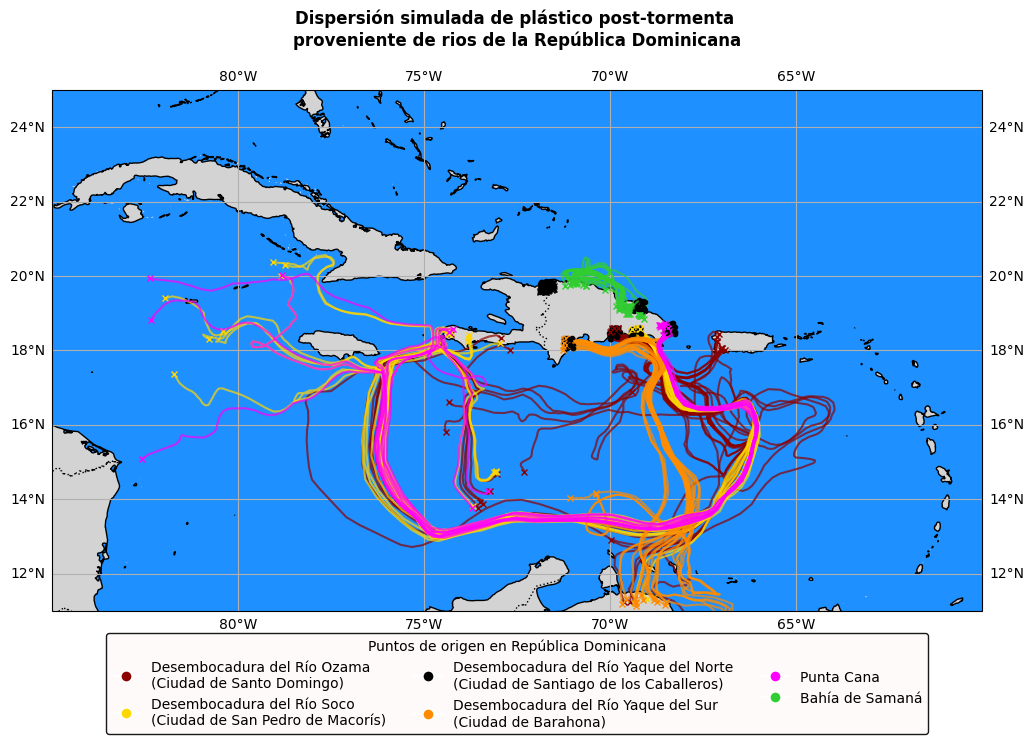

In [ ]:
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-85, -60, 11, 25], crs=ccrs.PlateCarree())

# Mapa base
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
ax.add_feature(cfeature.OCEAN, facecolor= 'dodgerblue')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Dibujar trayectorias
for p in particulas:
    # Línea de trayectoria
    ax.plot(p["lon_history"], p["lat_history"],
            color=p["color"], linewidth=1.5, alpha=0.7,
            transform=ccrs.PlateCarree())

    # Punto de inicio
    ax.plot(p["lon_history"][0], p["lat_history"][0],
            marker='o', color='black', markersize=3,
            transform=ccrs.PlateCarree())

    # Punto final (flecha o X)
    ax.plot(p["lon_history"][-1], p["lat_history"][-1],
            marker='x', color=p["color"], markersize=5,
            transform=ccrs.PlateCarree())

leyenda_puntos = [
    Line2D([0], [0], marker='o', color='w',
           label=p["label"],
           markerfacecolor=p["color"],
           markersize=8)
    for p in puntos_rd
]

ax.legend(
    handles=leyenda_puntos,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    frameon=True,
    framealpha= 0.9,
    edgecolor= 'black',
    facecolor= 'snow',
    title="Puntos de origen en República Dominicana"
)

plt.title("Dispersión simulada de plástico post-tormenta \nproveniente de rios de la República Dominicana", fontweight='bold', y= 1.07)
plt.show()

# **Calculo de Cantidad de Particulas que llegan a tierra**

In [ ]:
if np.isnan(u) or np.isnan(v):
    p["active"] = False

In [ ]:
total = len(particulas)
inactivas = sum(not p["active"] for p in particulas)
activas = sum(p["active"] for p in particulas)

print(f"Total de partículas: {total}")
print(f"Partículas que llegaron a tierra {inactivas}")
print(f"Partículas que siguen en el mar: {activas}")


Total de partículas: 240
Partículas que llegaron a tierra o salieron del dominio: 198
Partículas que siguen en el mar: 42
